In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns

sns.set_style('darkgrid')

In [2]:
def optimize_dataframe_for_memory(df):
 print("current memeor usage: ", df.memory_usage().sum() / 1024**2, "MB")

 for col in df.columns:
  _max = df[col].max()
  _min = df[col].min()
  if df[col].dtype  == 'int64':
   if _min > np.iinfo(np.int8).min and _max < np.iinfo(np.int8).max:
    df[col] = df[col].astype(np.int8)
   elif _min > np.iinfo(np.int16).min and _max < np.iinfo(np.int16).max:
    df[col] = df[col].astype(np.int16)
   elif _min > np.iinfo(np.int32).min and _max < np.iinfo(np.int32).max:
    df[col] = df[col].astype(np.int32)
  elif df[col].dtype == 'float64':
   if _min > np.finfo(np.float16).min and _max < np.finfo(np.float16).max:
    df[col] = df[col].astype(np.float16)
   elif _min > np.finfo(np.float32).min and _max < np.finfo(np.float32).max:
    df[col] = df[col].astype(np.float32)
  else:
   continue
 
 print("new memory usage: ", df.memory_usage().sum() / 1024**2, "MB")
 return df


In [3]:
data_set_location  = 'data/'
os.listdir(data_set_location)

['products.csv',
 'orders.csv',
 '.DS_Store',
 'order_products__train.csv',
 'departments.csv',
 'aisles.csv',
 'order_products__prior.csv',
 'sample_submission.csv']

In [4]:

departments_df = pd.read_csv(data_set_location + 'departments.csv')
aisles_df = pd.read_csv(data_set_location + 'aisles.csv')


orders_df = pd.read_csv(data_set_location + 'orders.csv')
product_df = pd.read_csv(data_set_location + 'products.csv')

order_products_train_df = pd.read_csv(data_set_location + 'order_products__train.csv')
order_products_prior_df = pd.read_csv(data_set_location + 'order_products__prior.csv')

## Merge dataset into single dataframe

In [5]:
df = pd.concat( [ order_products_train_df , order_products_prior_df ])

print("before merge" , df.shape)

df = pd.merge(df, product_df, on='product_id', how='left')
df = pd.merge(df, aisles_df, on='aisle_id', how='left')
df = pd.merge(df, departments_df, on='department_id', how='left')
df = pd.merge(df, orders_df, on='order_id', how='left')

print("after merge" , df.shape)


before merge (33819106, 4)
after merge (33819106, 15)


In [6]:
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs,112108,train,4,4,10,9.0
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs,112108,train,4,4,10,9.0
2,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0
3,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods,112108,train,4,4,10,9.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33819106 entries, 0 to 33819105
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   product_id              int64  
 2   add_to_cart_order       int64  
 3   reordered               int64  
 4   product_name            object 
 5   aisle_id                int64  
 6   department_id           int64  
 7   aisle                   object 
 8   department              object 
 9   user_id                 int64  
 10  eval_set                object 
 11  order_number            int64  
 12  order_dow               int64  
 13  order_hour_of_day       int64  
 14  days_since_prior_order  float64
dtypes: float64(1), int64(10), object(4)
memory usage: 4.0+ GB


In [8]:
df = optimize_dataframe_for_memory(df)

current memeor usage:  4128.308837890625 MB


new memory usage:  2031.902006149292 MB


# Aisle

### What Aisle is the most popular among customers ?

In [9]:
df_by_aisle = df.groupby('aisle')["reordered"].aggregate(['count', 'sum']).rename(columns={'count': 'total_orders', 'sum': 'reordered_count'})

df_by_aisle = df_by_aisle.sort_values('total_orders', ascending=False).reset_index()

In [10]:
df_by_aisle[:5]

,aisle,total_orders,reordered_count
0,fresh fruits,3792661,2726251.0
1,fresh vegetables,3568630,2123540.0
2,packaged vegetables fruits,1843806,1178700.0
3,yogurt,1507583,1034957.0
4,packaged cheese,1021462,598280.0


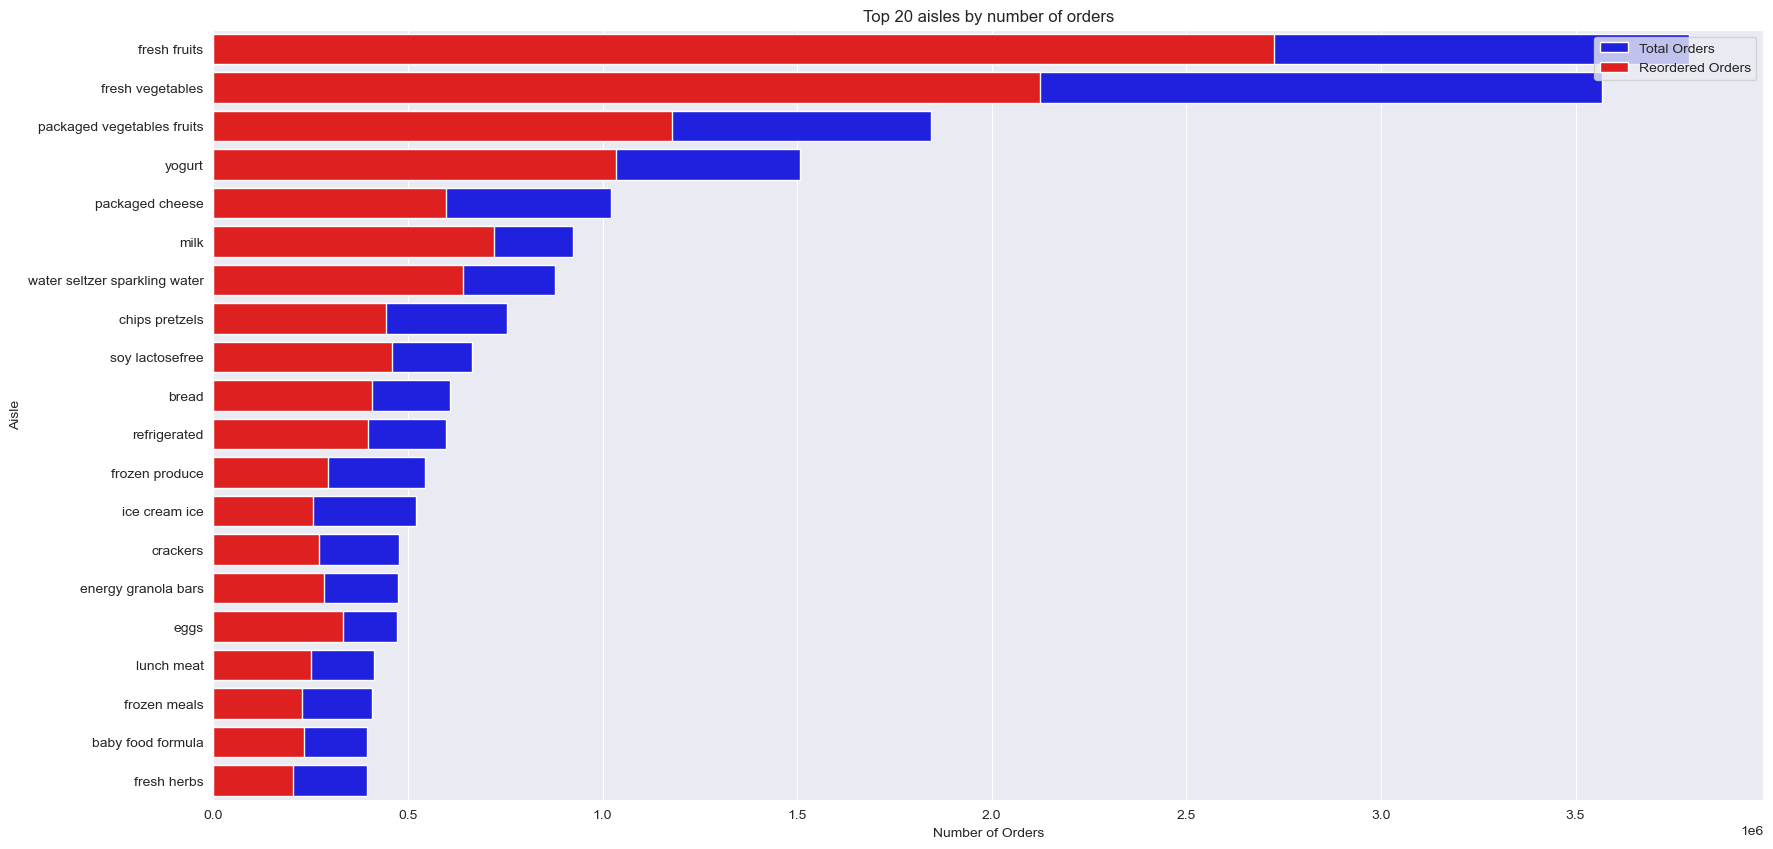

In [11]:
fig , axis = plt.subplots(figsize=(20, 10))
axis.set_title("Top 20 aisles by number of orders")

axis = sns.barplot(x='total_orders', y='aisle', data=df_by_aisle[:20], label='Total Orders', color='b')
axis = sns.barplot(x='reordered_count', y='aisle', data=df_by_aisle[:20], label='Reordered Orders', color='r')

axis.set_xlabel('Number of Orders')
axis.set_ylabel('Aisle')

axis.legend(loc='upper right')
fig.savefig('img/top_20_aisles.png')


## What Aisle has the most returning customers ?

In [12]:
df_by_aisle['reorder_ratio'] = df_by_aisle['reordered_count'] / df_by_aisle['total_orders']

df_by_aisle = df_by_aisle.sort_values('reorder_ratio', ascending=False).reset_index()

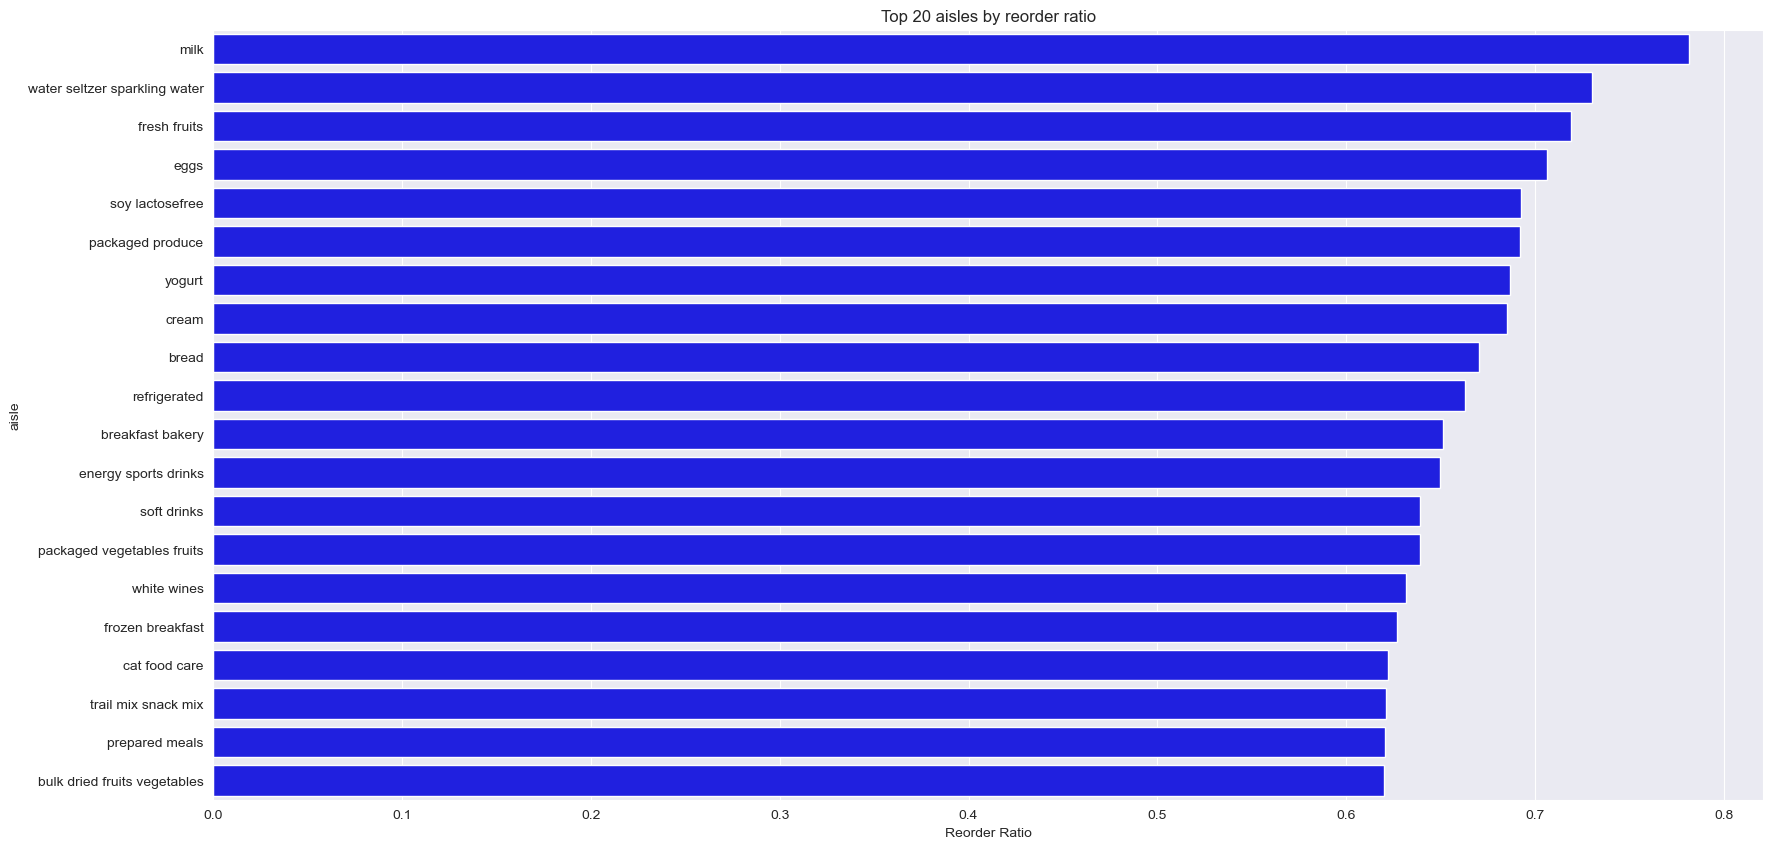

In [13]:
fig , axis = plt.subplots(figsize=(20, 10))

axis.set_title("Top 20 aisles by reorder ratio")

axis = sns.barplot(x='reorder_ratio', y='aisle', data=df_by_aisle[:20] , color='b')

axis.set_xlabel('Reorder Ratio')

fig.savefig('img/top_20_aisles_reorder_ratio.png')


### What Aisle has the least reorder ratio ?

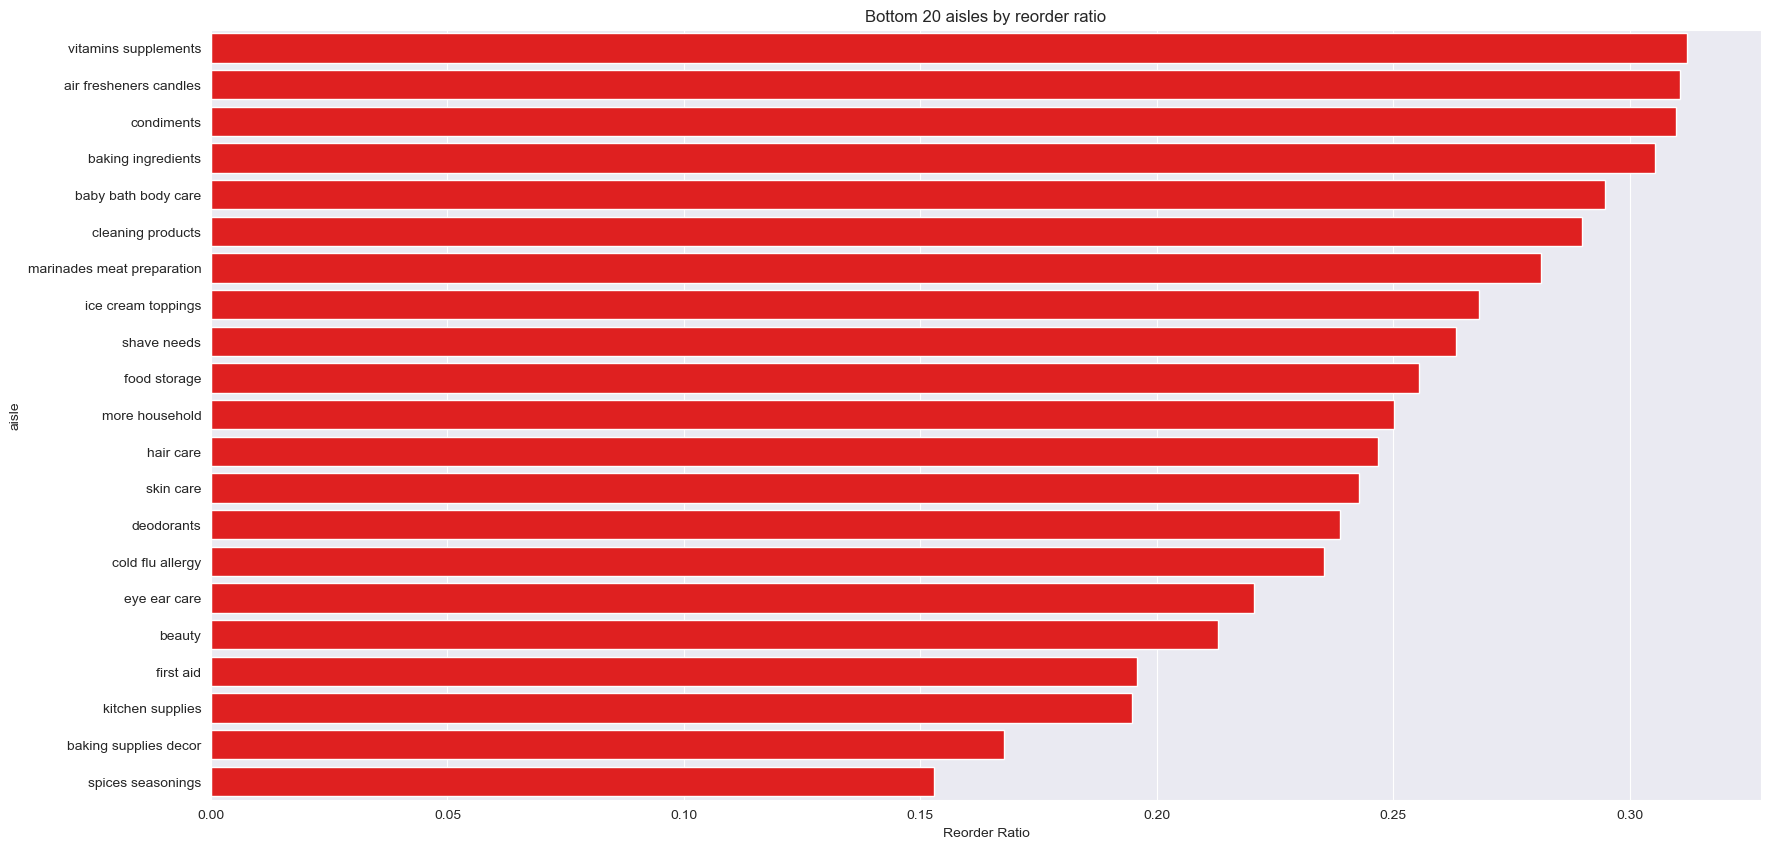

In [14]:
fig , axis = plt.subplots(figsize=(20, 10))

axis.set_title("Bottom 20 aisles by reorder ratio")

axis = sns.barplot(x='reorder_ratio', y='aisle', data=df_by_aisle[-21:] , color='r')

axis.set_xlabel('Reorder Ratio')

fig.savefig('img/bottom_20_aisles_reorder_ratio.png')


# Department

In [15]:
df_by_department =  df.groupby('department')['reordered'].aggregate(['count', 'sum']).rename(columns={'count': 'total_orders', 'sum': 'reordered_count'})
df_by_department = df_by_department.sort_values('total_orders', ascending=False).reset_index()

## Let's understand how customers reorder from the most popular departments

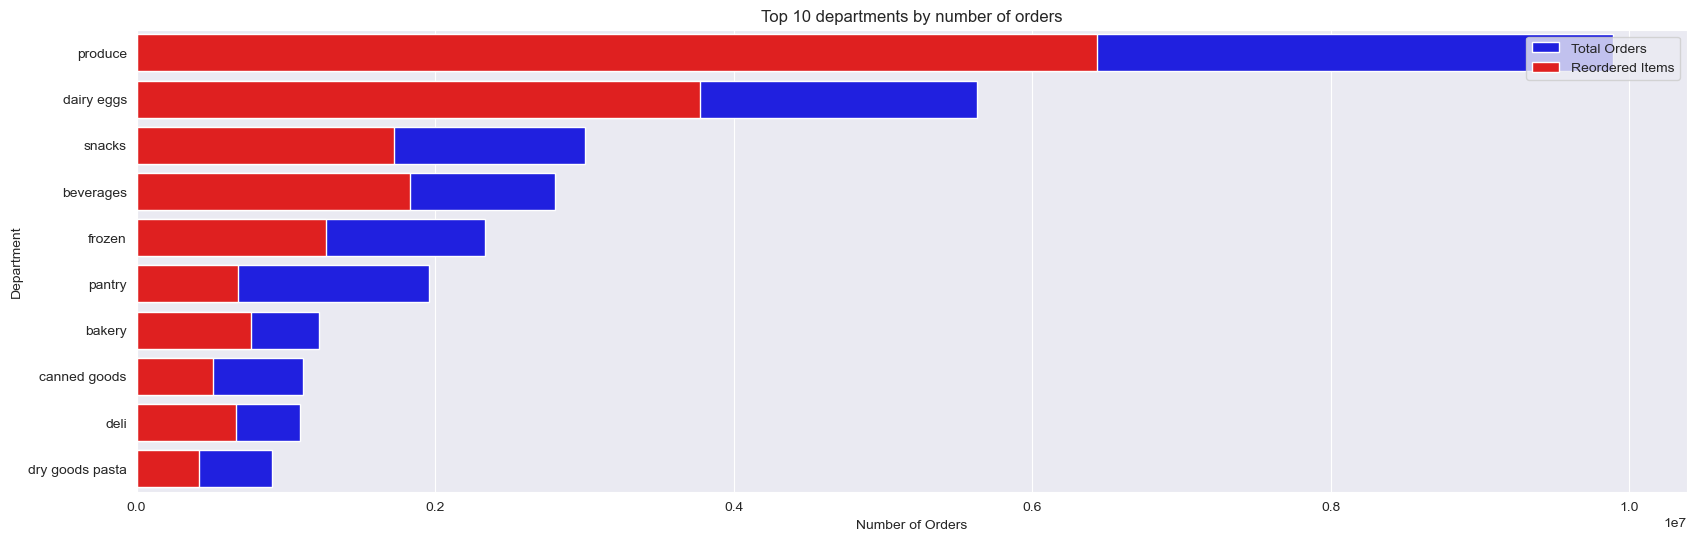

In [16]:
fig , axis =  plt.subplots(figsize=(20, 6))

axis = sns.barplot(x = 'total_orders' , y = 'department' , data = df_by_department[:10] , color = 'b' , label = 'Total Orders')
axis = sns.barplot(x = 'reordered_count' , y = 'department' , data = df_by_department[:10] , color = 'r' , label = 'Reordered Items')

axis.set_title("Top 10 departments by number of orders")
axis.set_xlabel("Number of Orders")
axis.set_ylabel("Department")

axis.legend(loc='upper right')

fig.savefig('img/top_10_departments.png')



### Let's understand which department has has the highest rate of returning customers

In [17]:
df_by_department['reorder_ratio'] = df_by_department['reordered_count'] / df_by_department['total_orders']
df_by_department = df_by_department.sort_values('reorder_ratio', ascending=False).reset_index()

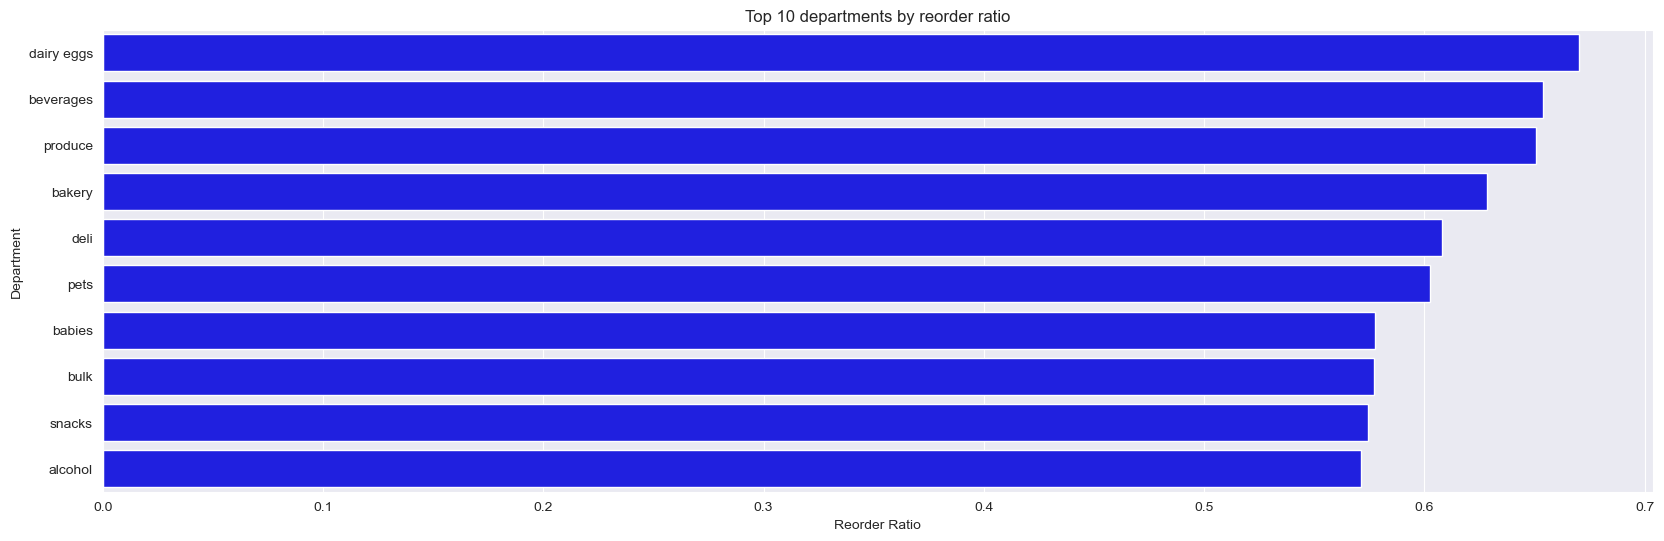

In [18]:
fig , axis =  plt.subplots(figsize=(20, 6))

axis = sns.barplot(x = 'reorder_ratio' , y = 'department' , data = df_by_department[:10] , color = 'b')

axis.set_title("Top 10 departments by reorder ratio")
axis.set_xlabel("Reorder Ratio")
axis.set_ylabel("Department")

fig.savefig('img/top_10_departments_reorder_ratio.png')

# Products

In [19]:
df_by_product = df.groupby('product_name')['reordered'].aggregate(['count', 'sum']).rename(columns={'count': 'total_orders', 'sum': 'reordered_count'})

df_by_product =  df_by_product.sort_values('total_orders', ascending=False).reset_index()

### Let's understand how customers treat their most popular items

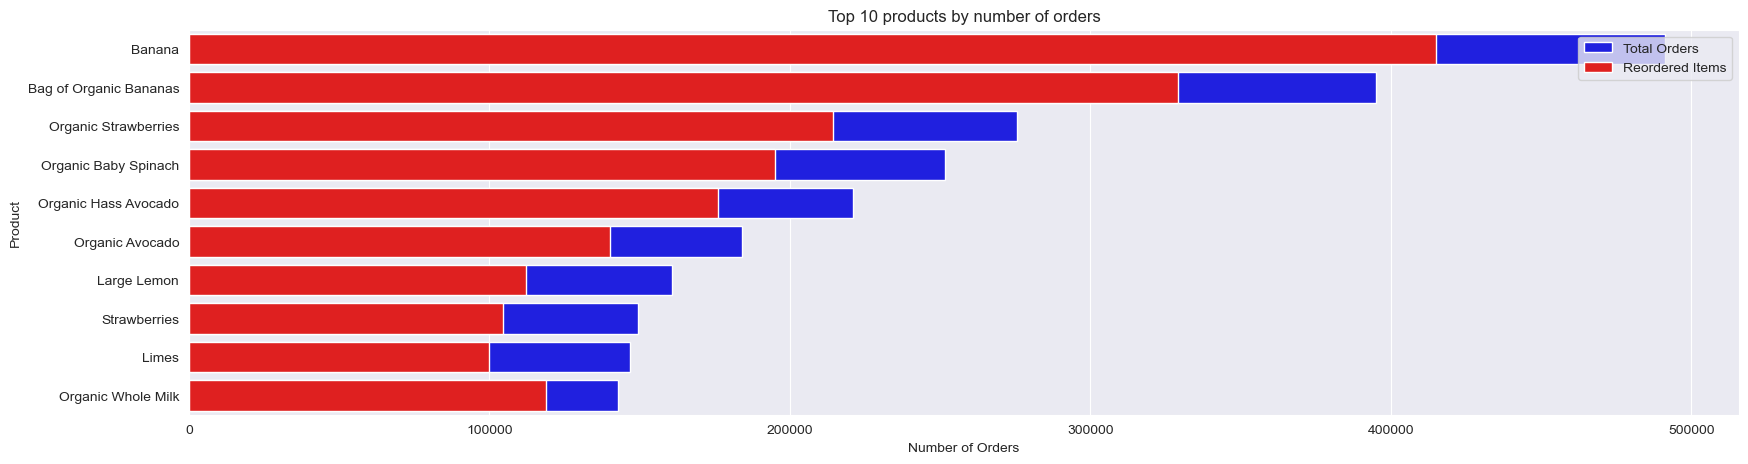

In [20]:
fig , axis = plt.subplots(figsize=(20, 5))

axis = sns.barplot( x = 'total_orders' , y = 'product_name' ,  data = df_by_product[:10] , color = 'b' , label = 'Total Orders')
axis = sns.barplot( x = 'reordered_count' , y = 'product_name' ,  data = df_by_product[:10] , color = 'r' , label = 'Reordered Items')

axis.set_title("Top 10 products by number of orders")
axis.set_xlabel("Number of Orders")
axis.set_ylabel("Product")

axis.legend(loc='upper right')

fig.savefig('img/top_10_products.png')



### Let's see which items have the best ratio by reorder

In [21]:
df_by_product['reorder_ratio'] = df_by_product['reordered_count'] / df_by_product['total_orders']
df_by_product = df_by_product.sort_values('reorder_ratio', ascending=False).reset_index()

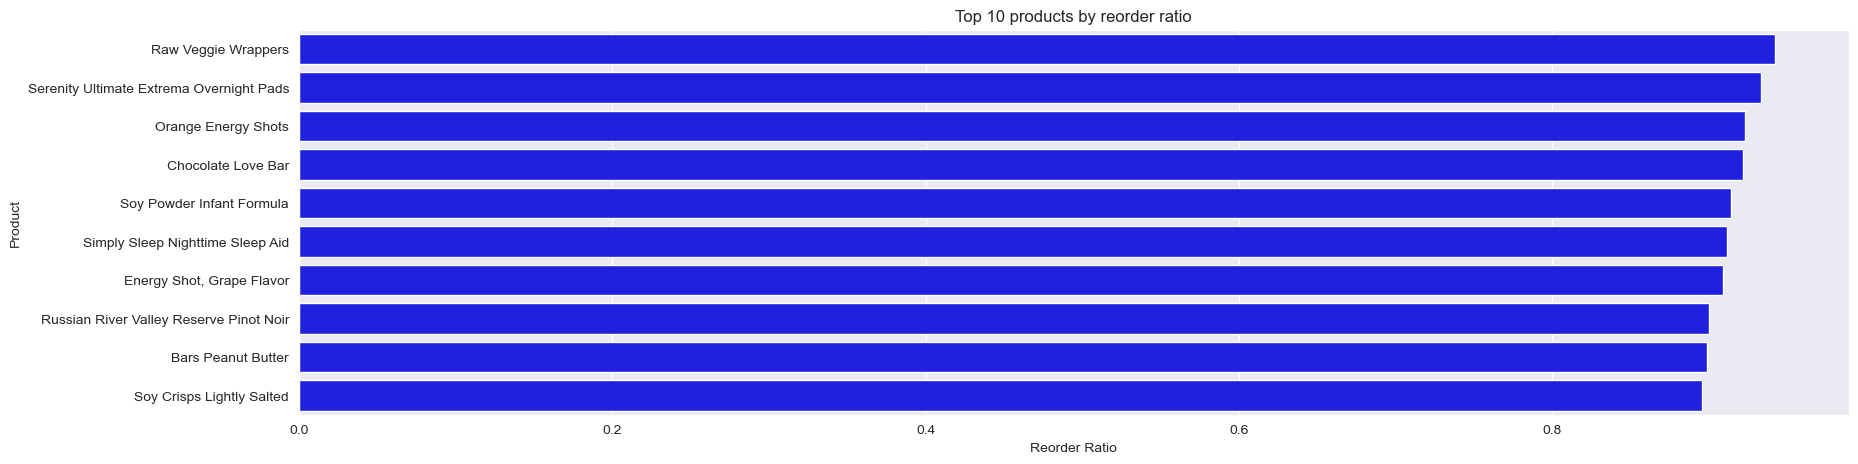

In [22]:
fig , axis = plt.subplots(figsize=(20, 5))
axis =  sns.barplot( x = 'reorder_ratio' , y = 'product_name' ,  data = df_by_product[:10] , color = 'b')

axis.set_title("Top 10 products by reorder ratio")
axis.set_xlabel("Reorder Ratio")
axis.set_ylabel("Product")

fig.savefig('img/top_10_products_reorder_ratio.png')

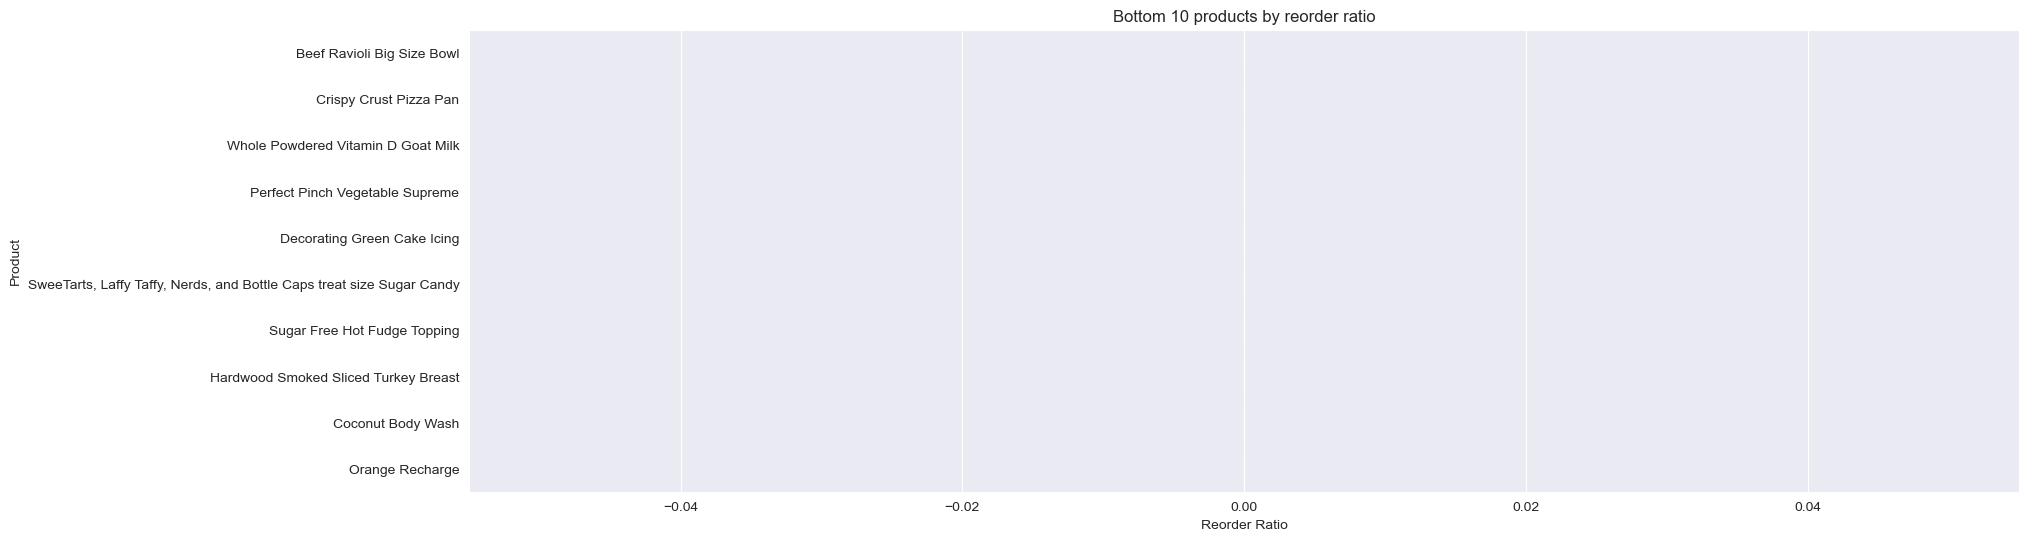

In [23]:
# worst products by reorder ratio
fig , axis =  plt.subplots(figsize=(20, 6))

axis = sns.barplot(x = 'reorder_ratio' , y = 'product_name' , data = df_by_product[-10:] , color = 'r')

axis.set_title("Bottom 10 products by reorder ratio")
axis.set_xlabel("Reorder Ratio")
axis.set_ylabel("Product")

fig.savefig('img/bottom_10_products_reorder_ratio.png')


In [24]:
df_by_product.tail(10)

,index,product_name,total_orders,reordered_count,reorder_ratio
49675,46275,Beef Ravioli Big Size Bowl,6,0.0,0.0
49676,46276,Crispy Crust Pizza Pan,6,0.0,0.0
49677,46277,Whole Powdered Vitamin D Goat Milk,6,0.0,0.0
49678,46278,Perfect Pinch Vegetable Supreme,6,0.0,0.0
49679,35548,Decorating Green Cake Icing,21,0.0,0.0
49680,39309,"SweeTarts, Laffy Taffy, Nerds, and Bottle Caps...",14,0.0,0.0
49681,46282,Sugar Free Hot Fudge Topping,6,0.0,0.0
49682,46283,Hardwood Smoked Sliced Turkey Breast,6,0.0,0.0
49683,46284,Coconut Body Wash,6,0.0,0.0
49684,49684,Orange Recharge,1,0.0,0.0


In [25]:
print( "The total number of products that never get reordered: ", df_by_product[df_by_product['reordered_count'] == 0].shape[0])

print( "The percentage of product that dont get reordered: ", f"{df_by_product[df_by_product['reordered_count'] == 0].shape[0] / df_by_product.shape[0] * 100:.2f}%")

The total number of products that never get reordered:  4082
The percentage of product that dont get reordered:  8.22%


## User level analysis

While we have identified the most popular products based on total sales, we haven't yet determined which products attract the highest number of unique customers. This distinction is important because our current analysis doesn't account for repeat purchases by the same customer.

### Let's understand which products attract the most unique users

In [26]:
df_by_product_user  =  df.groupby('product_name')['user_id'].nunique().reset_index().rename(columns={'user_id': 'unique_users'})
df_by_product_user=  df_by_product_user.sort_values('unique_users', ascending=False).reset_index()
df_by_product_user.head()

,index,product_name,unique_users
0,3677,Banana,76125
1,3472,Bag of Organic Bananas,65655
2,31923,Organic Strawberries,61129
3,28843,Organic Baby Spinach,56766
4,22415,Large Lemon,48614


### Analyzing the Relationship Between Unique Customers and Total Order 

In [27]:
df_by_product_user = pd.merge(df_by_product_user, df_by_product, on='product_name', how='left')

df_by_product_user =  df_by_product_user.drop(['index_x' ,  'index_y'], axis=1)

df_by_product_user.head()

,product_name,unique_users,total_orders,reordered_count,reorder_ratio
0,Banana,76125,491291,415166.0,0.845051
1,Bag of Organic Bananas,65655,394930,329275.0,0.833755
2,Organic Strawberries,61129,275577,214448.0,0.778178
3,Organic Baby Spinach,56766,251705,194939.0,0.774474
4,Large Lemon,48614,160792,112178.0,0.697659


### Let see the relationship between the amount of unique users a product has and the total orders it receives

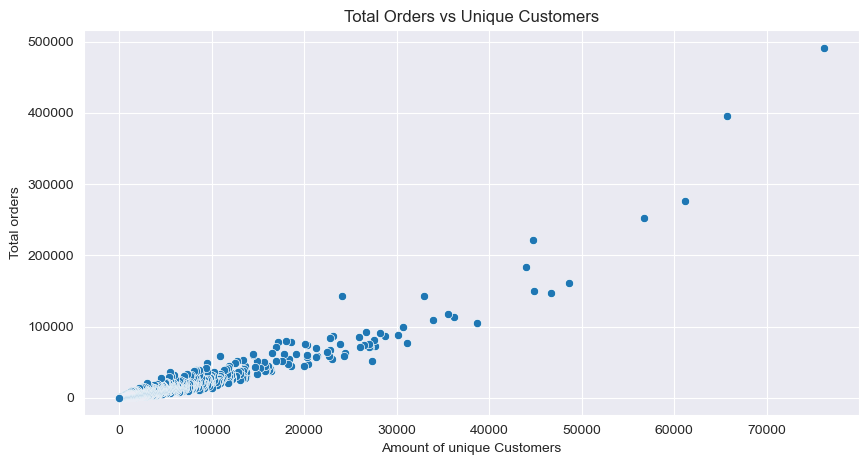

In [28]:
fig , axis =  plt.subplots( figsize = ( 10 , 5))

axis =  sns.scatterplot( x = 'unique_users',  y = 'total_orders' , data = df_by_product_user)

axis.set_title("Total Orders vs Unique Customers")

axis.set_xlabel("Amount of unique Customers")

axis.set_ylabel('Total orders')

fig.savefig('img/total_orders_vs_unique_customers.png')



### Let's understand if having a product having more unique customers has any impact on the reorder ratio of that product

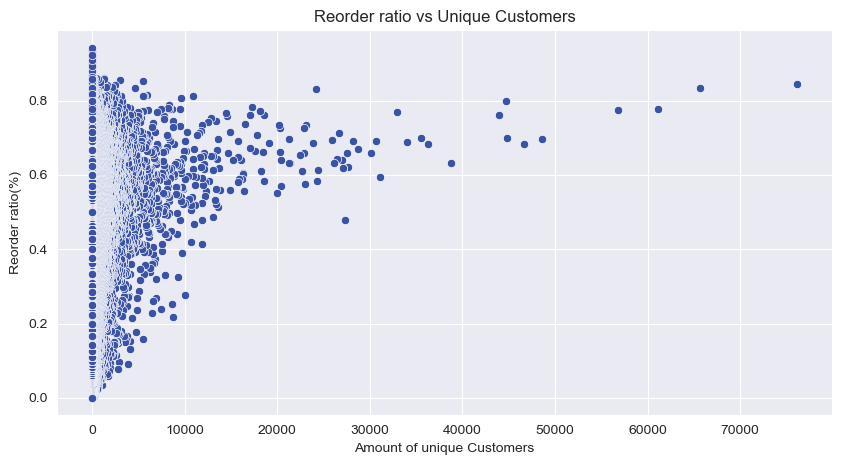

In [29]:
fig , axis =  plt.subplots( figsize = ( 10 , 5))

axis =  sns.scatterplot( x = 'unique_users',  y = 'reorder_ratio' , data = df_by_product_user , color = "#3a53a6")

axis.set_title("Reorder ratio vs Unique Customers")

axis.set_xlabel("Amount of unique Customers")

axis.set_ylabel('Reorder ratio(%)')

fig.savefig('img/reorder_ratio_vs_unique_customers.png')


## Position in cart Analysis

### We aim to investigate the following aspects of user behavior

 1.  Do users typically reorder products they add to their cart early or late in their shopping session?
 2. Why kind of products so they typicall have in their cart early on vs last into the shopping experience

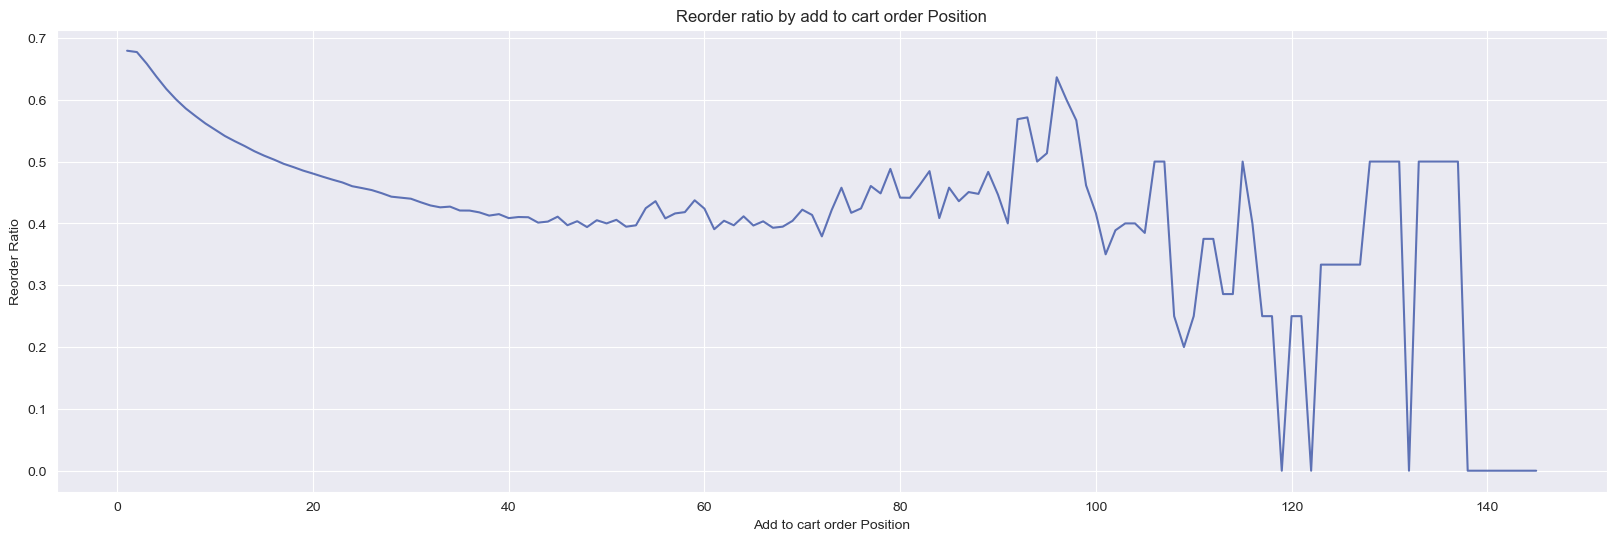

In [30]:
"""

Let's understand the impact of the postion on how likely a product is to be reordered.

"""

df_by_reorder = df.groupby('add_to_cart_order')['reordered'].mean().reset_index()

fig , axis = plt.subplots(figsize=(20, 6))

axis = sns.lineplot(x='add_to_cart_order', y='reordered', data=df_by_reorder, color = "#3a53a6" , alpha = 0.8)

axis.set_title("Reorder ratio by add to cart order Position")

axis.set_xlabel("Add to cart order Position")

axis.set_ylabel("Reorder Ratio")

fig.savefig('img/reorder_ratio_by_add_to_cart_order_position.png')



In [31]:
"""

Let's understand what product customers typically would have in their cart very early in the order.

"""

df_by_cart_position = df[df['add_to_cart_order'] <= 10]

df_by_cart_position = (df_by_cart_position.groupby('product_name')['add_to_cart_order']
                       .mean()
                       .reset_index(name='avg_cart_position')
                       .sort_values('avg_cart_position'))

df_by_cart_position.head(10)


,product_name,avg_cart_position
18107,Grain Free Beef & Egg,1.0
17288,Gluten Free Gold Lager,1.0
5616,Bromelain 500mg,1.0
39664,Seltzer Blueberry Lemonade,1.0
11570,Crystal Flakes Sea Salt,1.0
22198,L-Lysine 1000mg Tablets,1.0
30439,Organic Kale Spinach & Apple Greek Yogurt,1.0
44025,Swiss Style Lowfat '1% Chocolate Milk,1.0
42150,Splash Berry Blend,1.0
10561,Cooking Fuel,1.0


### Let's examine which products are in higher demand by the day of the week

In [32]:
df_by_product_dow = df.groupby(['order_dow' , 'product_name' ]).size().reset_index(name='counts')

df_by_product_dow = df_by_product_dow.sort_values(['order_dow', 'counts'], ascending=[True, False])

df_by_product_dow = df_by_product_dow.groupby('order_dow').head(5).reset_index(drop = True)


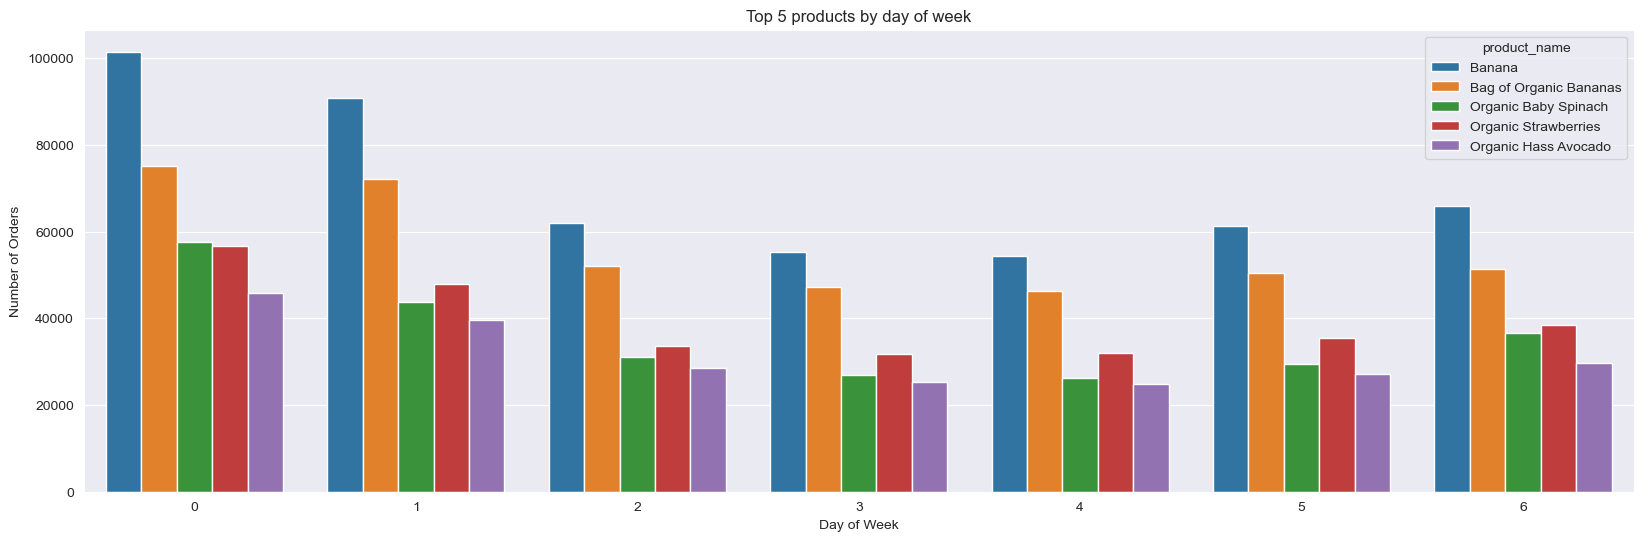

In [33]:
fig , axis =  plt.subplots( figsize = ( 20 , 6))

axis = sns.barplot(x = 'order_dow' , y = 'counts' , hue = 'product_name' , data = df_by_product_dow)

axis.set_title("Top 5 products by day of week")

axis.set_xlabel("Day of Week")

axis.set_ylabel("Number of Orders")

fig.savefig('img/top_5_products_by_day_of_week.png')